In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import logging

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Load all combined data
logger.info("Loading combined dataset")
df = pd.read_csv('../data/processed/all_majors_combined.csv')
logger.info(f"Loaded {len(df)} player & tournament records")

2025-11-22 18:03:42,036 - INFO - Loading combined dataset
2025-11-22 18:03:42,045 - INFO - Loaded 1384 player & tournament records


# Model 1: Pooled Linear Regression

Goal: identify which performance variables have the strongest relationship with scoring.

In [21]:
# Target value: total_score
# Features: performance metrics
# Performance metrics that aren't taken into consideration (to avoid multicollinarity):
# - sg_total: bc it's a sum of all strokes gained metrics)
# - sg_t2g: sum of sg_ott + sg_app + sg_arg
# - sg_bs: sum of sg_ott + sg_app

# Define feature groups
off_tee = ['distance', 'accuracy', 'sg_ott']
approach = ['sg_app', 'prox_fw', 'prox_rgh']
short_game = ['sg_arg', 'scrambling']
putting = ['sg_putt']
ball_striking = ['gir']
shot_quality = ['great_shots', 'poor_shots']

# Combine all features together
features = off_tee + approach + short_game + putting + ball_striking + shot_quality

print(f"\nUsing {len(features)} features:")
print(features)

# Define X (features) and y (target)
X = df[features]
y = df['total_score']

print(f"\nTraining on {len(X)} records")


Using 12 features:
['distance', 'accuracy', 'sg_ott', 'sg_app', 'prox_fw', 'prox_rgh', 'sg_arg', 'scrambling', 'sg_putt', 'gir', 'great_shots', 'poor_shots']

Training on 1384 records


In [23]:
# Fit the pooled linear regression model
model = LinearRegression()
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

# Evaluate the model performance
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print("POOLED LINEAR REGRESSION RESULTS")
print(f"\nR² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f} strokes")
print(f"\nIntercept: {model.intercept_:.3f}")

POOLED LINEAR REGRESSION RESULTS

R² Score: 0.811
RMSE: 3.118 strokes

Intercept: 59.336


** Model performance: **
With R² = 0.811, the model explains about 81% of scoring variation, which is solid.


In [24]:
# Display coefficients
coefficients = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("\nFeature Importance (Coefficients):")
print(coefficients)


Feature Importance (Coefficients):
        Feature  Coefficient
9           gir   -44.795840
7    scrambling   -20.247789
1      accuracy    -8.123509
8       sg_putt    -2.418497
6        sg_arg    -1.815844
11   poor_shots     0.853676
3        sg_app    -0.845507
2        sg_ott    -0.701729
10  great_shots    -0.242274
4       prox_fw     0.073597
0      distance    -0.061456
5      prox_rgh     0.033523


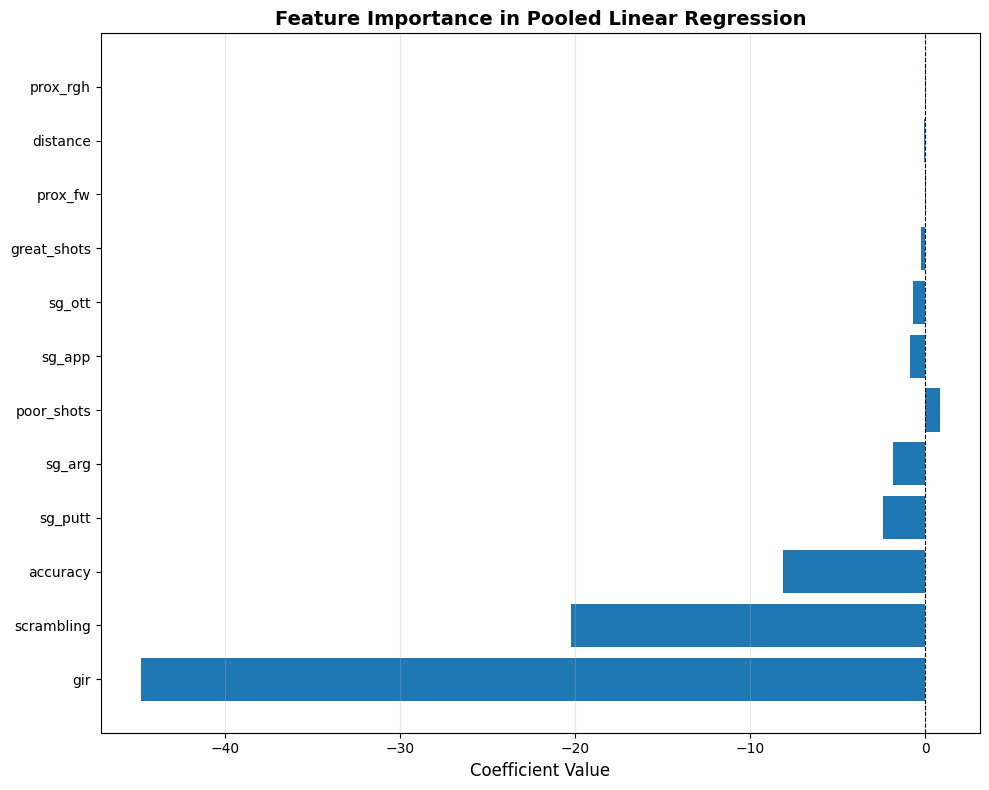

In [25]:
# Visualize coefficients
plt.figure(figsize=(10, 8))
plt.barh(coefficients['Feature'], coefficients['Coefficient'])
plt.xlabel('Coefficient Value', fontsize=12)
plt.title('Feature Importance in Pooled Linear Regression', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

**Coefficients takeaways:** 

Greens in regulation (GIR) is the performance variable that has the highest impact in scoring, meaning that the most important is to get to the green as soon as possible. 

Scrambling is the second most important variable which suggests the importance of making up and saving par after missing greens.


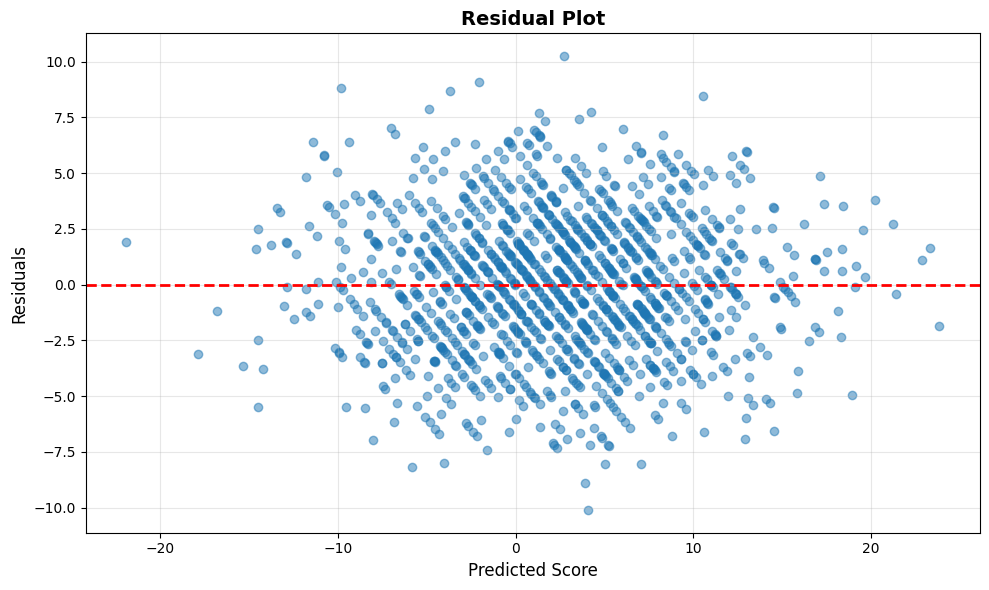

In [26]:
# Make a residual plot to see how well the model fits
residuals = y - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted Score', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title('Residual Plot', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Residual Plot Analysis:**

It can be observed that the residuals are mostly randomly scattered around zero, which is what we want to see. 
However, there is a bit of funnel shape indicating a bit of heteroscedasticity (the spread gets wider for higher predicted scores). 
This means that the model is a bit less precise for extreme performance. 
Vertical stripes are also observed, which might be because different majors have different scoring conditions

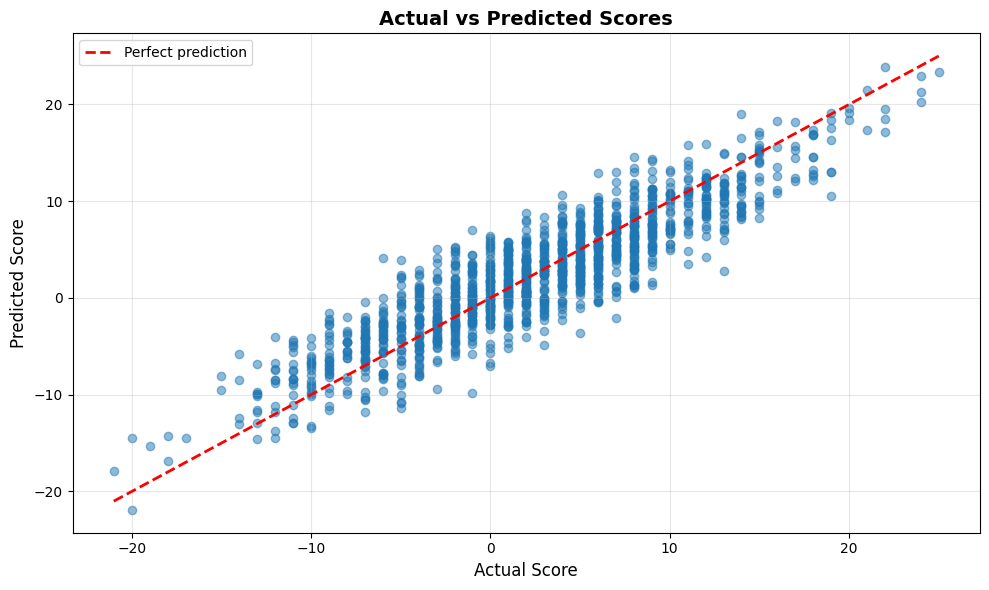

In [27]:
# Make a plot showing actual vs predicted score
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2, label='Perfect prediction')
plt.xlabel('Actual Score', fontsize=12)
plt.ylabel('Predicted Score', fontsize=12)
plt.title('Actual vs Predicted Scores', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Actual vs Predicted Analysis:**

It can be observed that there is a strong linear relationship between the actual and the predicted scores (most points are close to the diagonal)

# Model 2: Per-Major Linear Regression

Goal: identify how skill importance varies across different Major championships.

Each major has unique course characteristics that might favor different skills.
